## PJM Hourly Energy Consumption Data
* Notebook source -> https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet
* Dataset -> https://www.kaggle.com/robikscube/hourly-energy-consumption

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import os

In [3]:
data_dir = '/Users/robin/kaggle/hourly-energy-consumption/'
os.listdir(data_dir)

['est_hourly.paruqet',
 'PJMW_hourly.csv',
 'pjm_hourly_est.csv',
 'PJM_Load_hourly.csv',
 'DAYTON_hourly.csv',
 'NI_hourly.csv',
 'PJME_hourly.csv',
 'FE_hourly.csv',
 'DOM_hourly.csv',
 'EKPC_hourly.csv',
 'DEOK_hourly.csv',
 'DUQ_hourly.csv',
 'AEP_hourly.csv',
 'COMED_hourly.csv']

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [4]:
pjme = pd.read_csv(data_dir+'PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [6]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


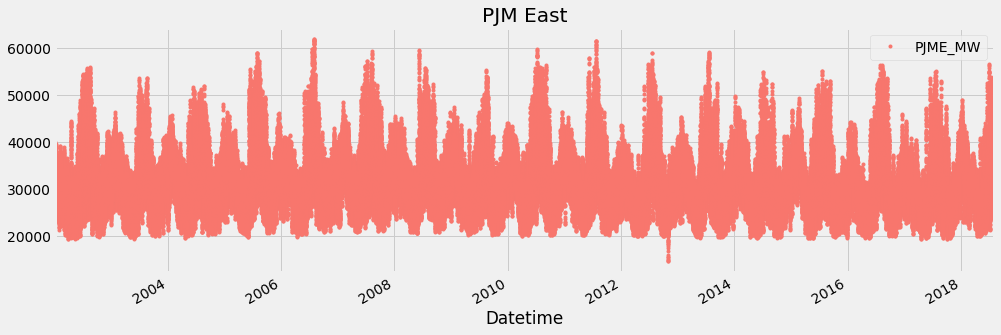

In [5]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# EDA

We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [8]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends
- Power demand has strong daily and seasonal properties.
- Day of week also seems to show differences in peaks

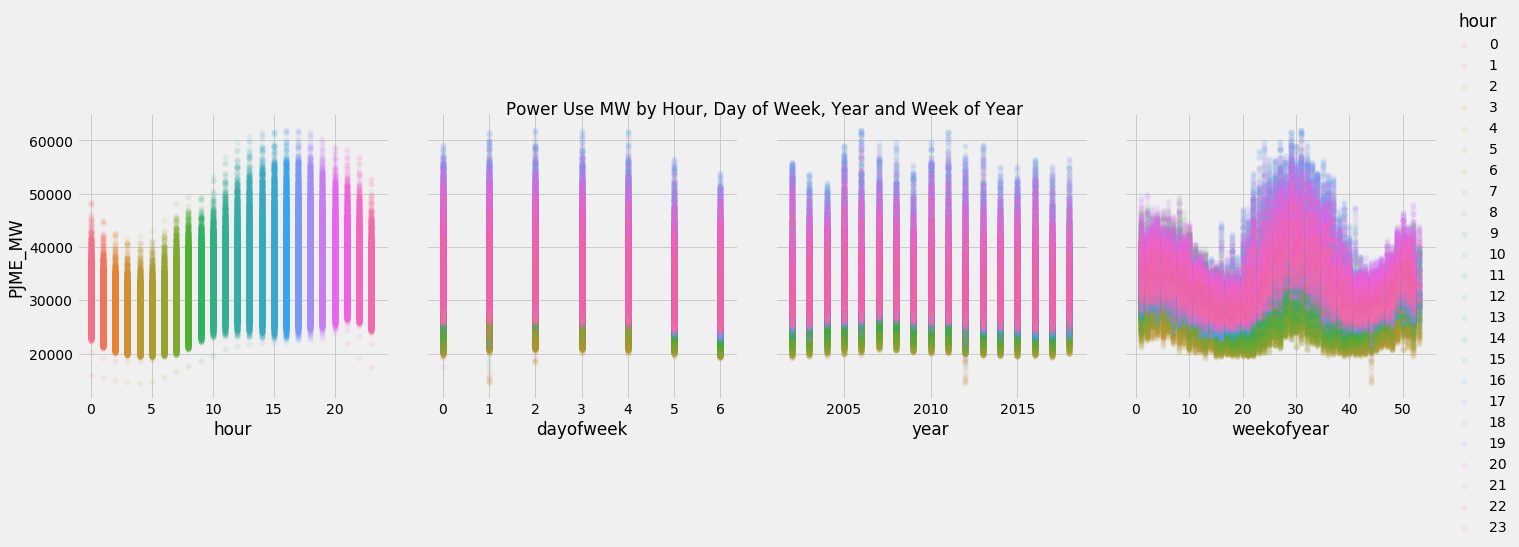

In [9]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [10]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

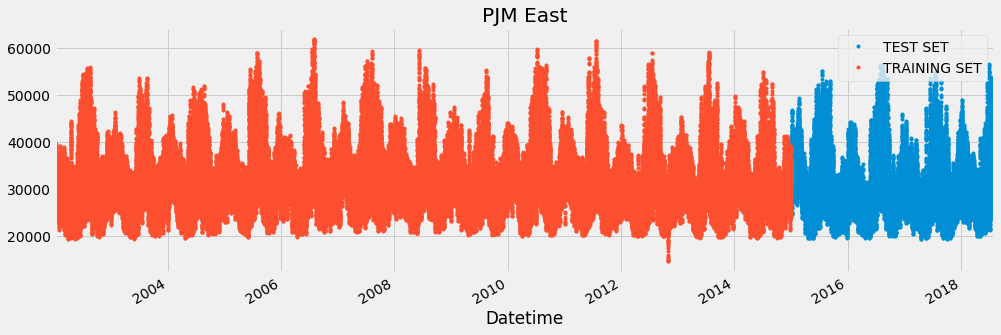

In [11]:
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [12]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [13]:
# Setup and train model
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [14]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [12]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.768254,24105.755085,33076.079554,31214.768254,31214.768254,-2864.261748,-2864.261748,-2864.261748,-4430.327494,-4430.327494,-4430.327494,1281.386957,1281.386957,1281.386957,284.678790,284.678790,284.678790,0.0,0.0,0.0,28350.506505
1,2015-01-01 02:00:00,31214.731338,22559.251763,31431.808784,31214.731338,31214.731338,-4368.619332,-4368.619332,-4368.619332,-5927.219491,-5927.219491,-5927.219491,1272.629269,1272.629269,1272.629269,285.970889,285.970889,285.970889,0.0,0.0,0.0,26846.112005
2,2015-01-01 03:00:00,31214.694422,21720.500865,30378.597549,31214.694422,31214.694422,-5240.326860,-5240.326860,-5240.326860,-6790.297120,-6790.297120,-6790.297120,1262.665752,1262.665752,1262.665752,287.304507,287.304507,287.304507,0.0,0.0,0.0,25974.367562
3,2015-01-01 04:00:00,31214.657506,21510.725481,30101.723980,31214.657506,31214.657506,-5381.914966,-5381.914966,-5381.914966,-6922.214631,-6922.214631,-6922.214631,1251.619994,1251.619994,1251.619994,288.679670,288.679670,288.679670,0.0,0.0,0.0,25832.742540
4,2015-01-01 05:00:00,31214.620591,22108.052717,31048.219790,31214.620591,31214.620591,-4707.617961,-4707.617961,-4707.617961,-6237.342157,-6237.342157,-6237.342157,1239.627794,1239.627794,1239.627794,290.096402,290.096402,290.096402,0.0,0.0,0.0,26507.002630


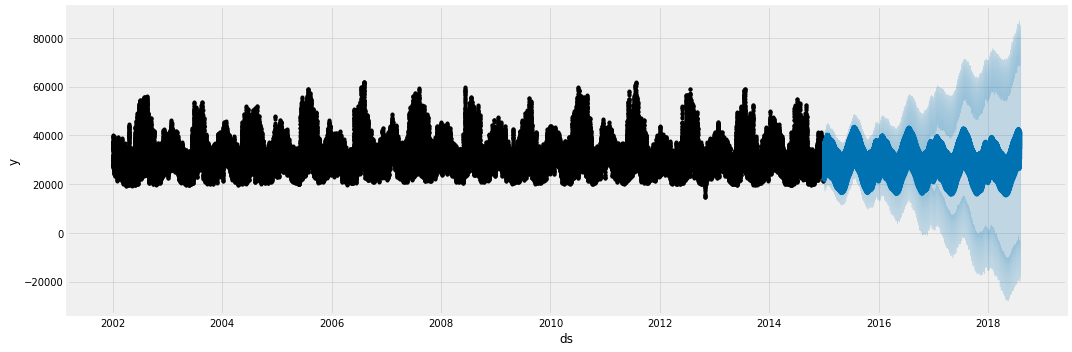

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst, ax=ax)
plt.show()

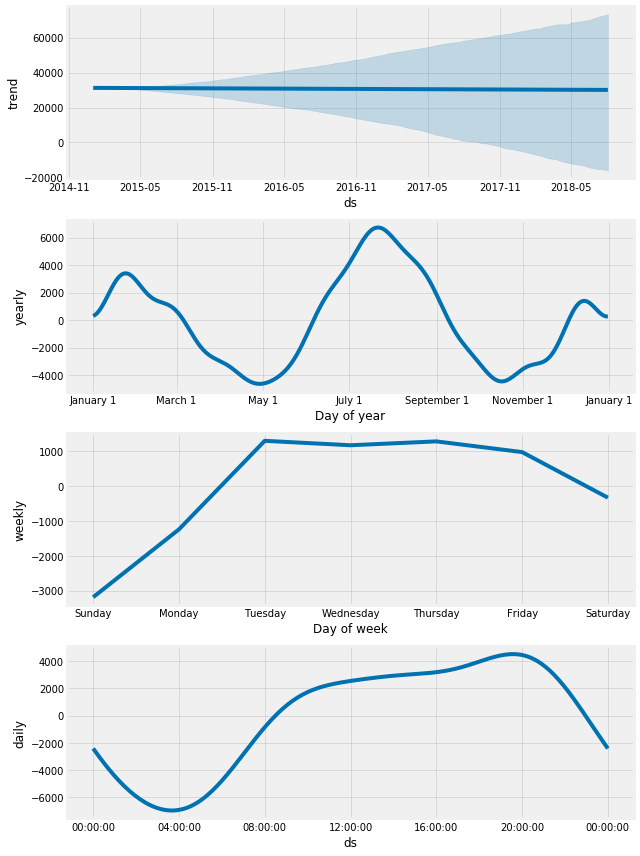

In [14]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

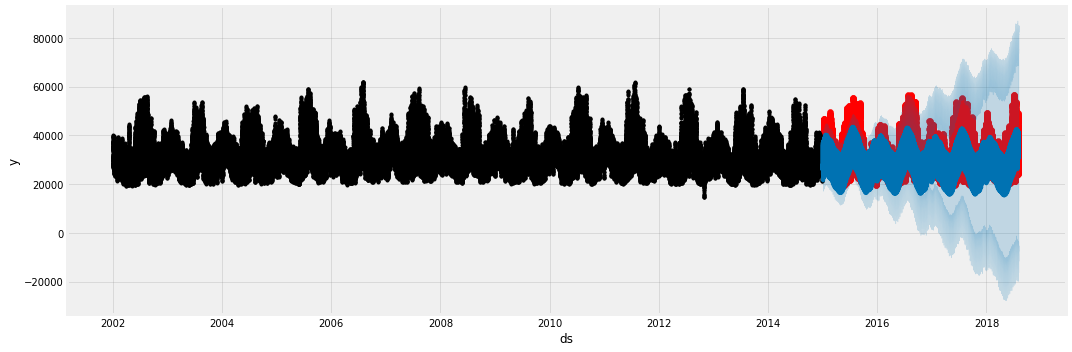

In [15]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Look at first month of predictions

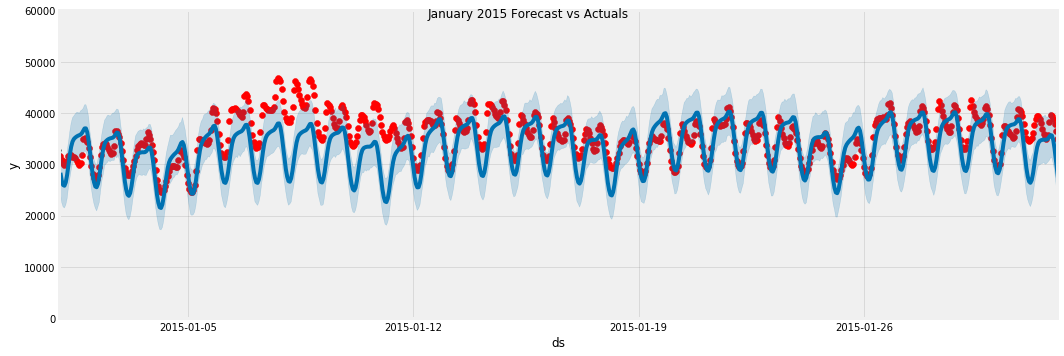

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

# Single Week of Predictions

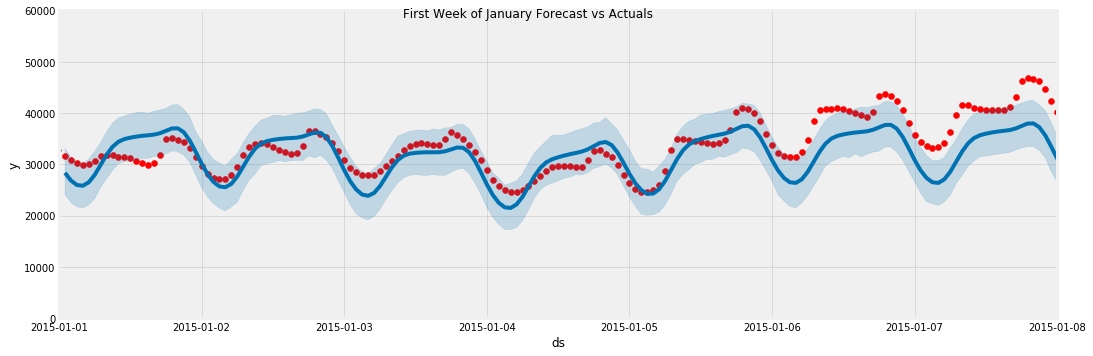

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

# Error Metrics

Our RMSE error is 43761675  
Our MAE error is 5181.78  
Our MAPE error is 16.5%

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE):
[Check that out here](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-xgboost/)

In [18]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

43761675.09158127

In [19]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.782050398612

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512109913326153

# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

In [21]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(), end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(), end=pjme_test.index.max())

In [22]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']].reset_index().rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [23]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [24]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index().rename(columns={'Datetime':'ds', 'PJME_MW':'y'}))

## Predict With Holidays

In [25]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## Plot Holiday Effect

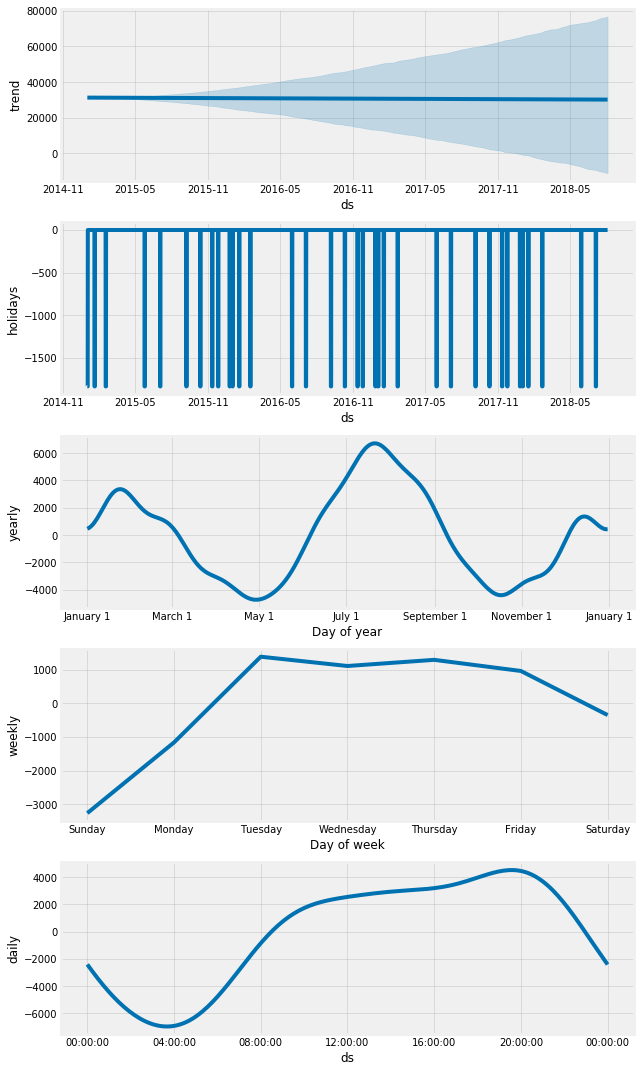

In [26]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Error Metrics with Holidays Added
Suprisingly the error has gotten worse after adding holidays.

In [27]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

43854192.0930847

In [28]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5188.894101894623

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.54692166186205

# Compare Models Just for Holiday Dates
Lets plot Forecast model with and without holidays for 4th of July. It does look like the model with holidays is more accurate for this holiday.

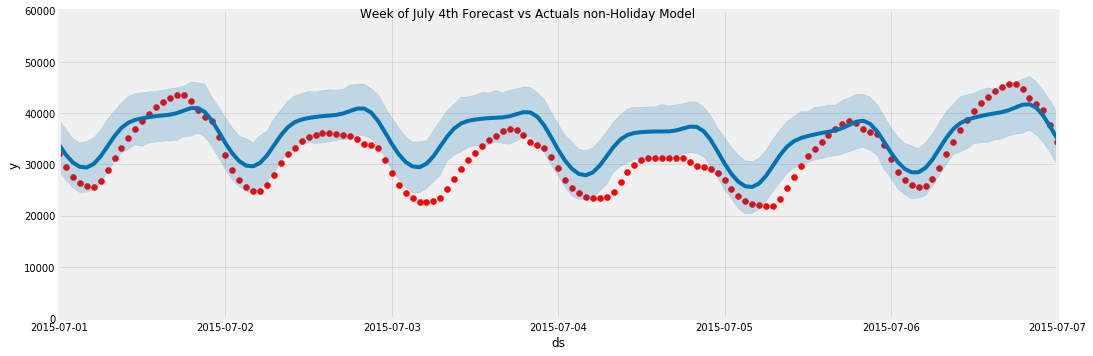

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='07-01-2015', upper='07-7-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

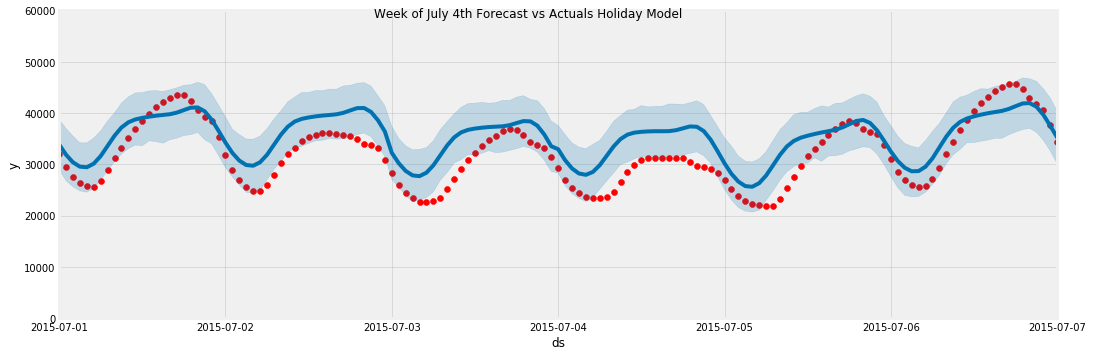

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015', upper='07-7-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

## Compare Error for just 4th of July
The error has gone down for this date.

In [32]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [33]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2160.288544948389

In [34]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2159.810721702265

# Error of all Holidays
- Holiday error has gone up!

In [35]:
holiday_list = holiday_df['ds'].tolist()

In [36]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')

In [37]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5225.708533591265

In [38]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

5110.4751401038375

# Identify Error by holiday
- We can see different holidays respond differently in this model. The model would perform better if we specifically identify holidays instead of lumping them all together as "USFederalHolidays"

In [39]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'{hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \t MAE (Holiday Model): {hol_model_error:0.1f} \t Diff {diff:0.1f}')

January 01, 2015:    
 MAE (non-holiday model): 3091.1 	 MAE (Holiday Model): 2672.4 	 Diff 418.7
January 19, 2015:    
 MAE (non-holiday model): 2414.6 	 MAE (Holiday Model): 2088.2 	 Diff 326.3
February 16, 2015:    
 MAE (non-holiday model): 11107.1 	 MAE (Holiday Model): 12754.1 	 Diff -1647.0
May 25, 2015:    
 MAE (non-holiday model): 1563.2 	 MAE (Holiday Model): 1614.0 	 Diff -50.8
July 03, 2015:    
 MAE (non-holiday model): 6054.3 	 MAE (Holiday Model): 4313.2 	 Diff 1741.1
September 07, 2015:    
 MAE (non-holiday model): 3851.8 	 MAE (Holiday Model): 4310.6 	 Diff -458.7
October 12, 2015:    
 MAE (non-holiday model): 1586.4 	 MAE (Holiday Model): 1868.5 	 Diff -282.0
November 11, 2015:    
 MAE (non-holiday model): 2047.7 	 MAE (Holiday Model): 1586.3 	 Diff 461.4
November 26, 2015:    
 MAE (non-holiday model): 4667.0 	 MAE (Holiday Model): 3790.4 	 Diff 876.6
December 25, 2015:    
 MAE (non-holiday model): 7565.0 	 MAE (Holiday Model): 5899.7 	 Diff 1665.4
January 01, 2

# Plot Error of Each Forecast
- We can see that both of our models generalize well, but struggle with peak demand days.
- Seems to be under forecasting many days.

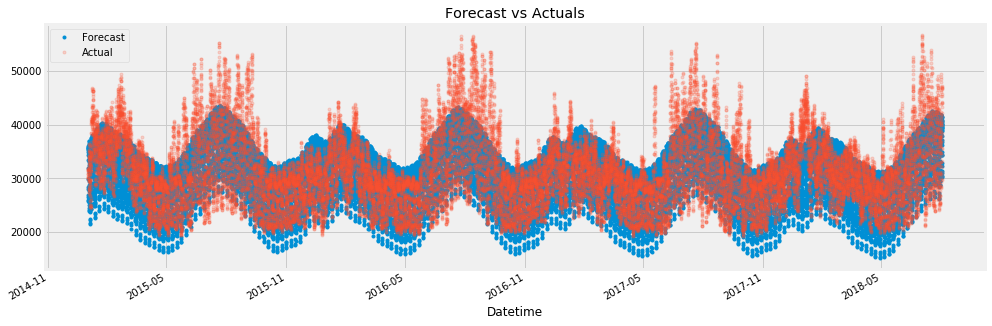

In [40]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

# Data Cleaning
- Data cleaning is a very important part of the forecasting process. If the input data contains garbage values, the forecast will use them when making predictions and could cause serious issues.
- We notice in the training data that we have some bad measurements where the values are much less. Could these be causing the under forecasting? Lets try removing this bad data.

This plot shows the bad data highlighted in red.

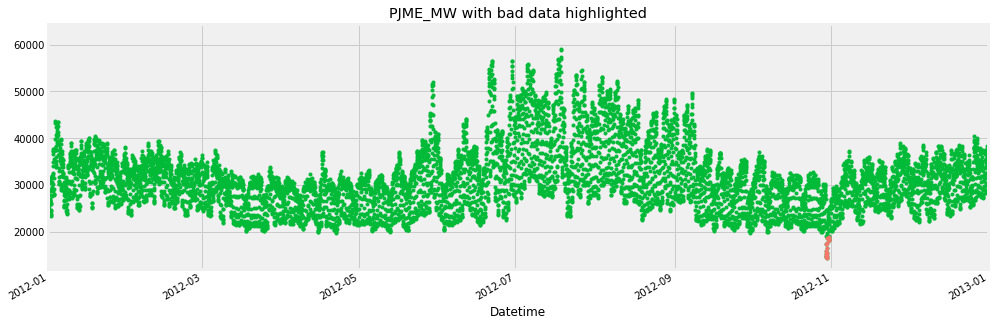

In [41]:
ax = pjme_train.plot(style='.', figsize=(15,5), color=color_pal[3],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013'))
_ = pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)

In [42]:
# Clean Data
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Train model on clean data
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'}))

# Predict on training set with clean model
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

After cleaning we see a slight improvement in score compared to the first model. More data cleaning, along with holidays could yield even better results. Give it a try!

In [43]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_clean['yhat'])
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_clean['yhat'])
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 43768672.1997 - MAE 5181.4354 - MAPE 16.5101


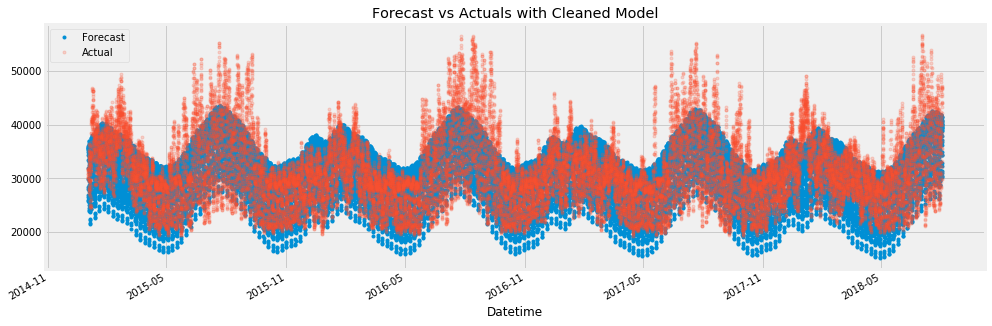

In [44]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'].plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()